In [1]:
import qutip, pickle, sys
import matplotlib.pyplot as plt 
import numpy as np
import scipy.optimize as opt 
import scipy.linalg as linalg
import time as time
import math, cmath
import auxiliary_library as me

from IPython.display import display, Math, Latex
np.set_printoptions(threshold=1.e-9,linewidth=120,precision=3, suppress=True, formatter={"float":lambda x: str(.001*int(1000*x))})

In [2]:
N=2; chain_type = "XYZ"; k_B = 1; temp = 2e-1

### Construcción de los operadores
spin_ops_list = me.one_body_spin_ops(N)
identity_op = spin_ops_list[0][0]
ts = np.linspace(0, 5.,500)  

### Heisenberg Hamiltonian
Hamiltonian_paras = [.2, .15, .1, 1.]
H_H = me.Heisenberg_Hamiltonian(op_list = spin_ops_list, chain_type = chain_type,
                                size = N, Hamiltonian_paras = Hamiltonian_paras,
                                closed_bcs = True, visualization = False)

### classical operators 

cl_ops, label_ops = me.classical_ops(H_H, N, spin_ops_list, False)
magnetization = sum(spin_ops_list[3][a] for a in range(len(spin_ops_list[3])))
neel_operator = sum((-1)**a * spin_ops_list[3][a] for a in range(len(spin_ops_list[3])))

cl_ops["magnetization"] = magnetization; label_ops.append("magnetization")
cl_ops["neel_op"] = neel_operator; label_ops.append("neel_op")
print("Are all the operators Hermitian?:", me.basis_hermitian_check(cl_ops))

Are all the operators Hermitian?: [True, True, True, True, True, True, True, True, True, True]


In [5]:
def process_multiple_proj_evs(init_coeff_list,
                              timespan, 
                              range_temps, 
                              process_different_ref_temps = False):
    
    if process_different_ref_temps:
        depth_and_seed_ops = [(1, cl_ops["identity_op"]), 
                              (1, H_H), 
                              (4, spin_ops_list[1][0]),
                             ]
        labels = ["Temp_" + str(i) for i in range(len(range_temps))]
        observables = list(cl_ops.values())
        
        mutiple_ev_results = {}
        multiple_init_configs = {}; multiple_evs_data = {}; multiple_dict_res_proj_ev = {}; multiple_res_exact = {}
        
        for Temp_Ref in range_temps:
            print("Processing step: ", range_temps.index(Temp_Ref), "and temperature ", Temp_Ref)
            
            loc_coeff_list = init_coeff_list
            
            beta_ref = (1/Temp_Ref)
            K_ref = - beta_ref * .5 * spin_ops_list[1][0]
            rho_ref = (K_ref).expm()
            custom_rho_ref = rho_ref/rho_ref.tr()
            
            assert me.is_density_op(custom_rho_ref), "Error: rho_ref is not a density operator"
            
            init_configs_MFT_state, evs_data, dict_res_proj_ev, res_exact = me.d_depth_proj_ev(
                temp_ref = Temp_Ref, temp_rho = temp, 
                timespan = timespan, 
                Hamiltonian = H_H, lagrange_op = None,
                depth_and_seed_ops = depth_and_seed_ops, observables = observables, 
                label_ops = label_ops, coeff_list = loc_coeff_list, 
                custom_ref_state = custom_rho_ref, 
                rho_ref_thermal_state = False,
                rho_ref_equal_rho0 = False, visualize_H_evs = False, 
                visualization_nonherm = False, visualize_expt_vals = False, visualize_diff_expt_vals = False
                )
            
            multiple_init_configs["init_configs_T" + str(range_temps.index(Temp_Ref))] = init_configs_MFT_state
            multiple_evs_data["evs_data_T" + str(range_temps.index(Temp_Ref))] = evs_data
            multiple_dict_res_proj_ev["dict_res_proj_ev_T" + str(range_temps.index(Temp_Ref))] = dict_res_proj_ev
            multiple_res_exact["res_exact_T" + str(range_temps.index(Temp_Ref))] = res_exact
                        
        mutiple_ev_results["init_configs_all"] = multiple_init_configs
        mutiple_ev_results["evs_data_all"] = multiple_evs_data
        mutiple_ev_results["dict_res_proj_ev_all"] = multiple_dict_res_proj_ev
        mutiple_ev_results["res_exact_all"] = multiple_res_exact
            
        return mutiple_ev_results

In [6]:
timespan = np.linspace(0, 10, 100)
coeff_list = [0, 0., .5, .0, .0, .0] 
range_temps = [2e-1 * 2**i for i in range(4)]

multiple_ev_results = process_multiple_proj_evs(init_coeff_list = coeff_list, timespan = ts,
                                                range_temps = range_temps,
                                                process_different_ref_temps = True)

Processing step:  0 and temperature  0.2
1. Processing reference state ===>
^^##. custom reference state chosen
2. using a base of size  6
3. rho_ref:  Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[0.249 0.0 -0.212 0.0]
 [0.0 0.249 0.0 -0.212]
 [-0.212 0.0 0.25 0.0]
 [0.0 -0.212 0.0 0.25]]
The basis is orthonormal and hermitian
3. constructing rho0 from the coeff. list and orth. basis
Processing step:  1 and temperature  0.4
1. Processing reference state ===>
^^##. custom reference state chosen
2. using a base of size  6
3. rho_ref:  Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[0.249 0.0 -0.138 0.0]
 [0.0 0.249 0.0 -0.138]
 [-0.138 0.0 0.25 0.0]
 [0.0 -0.138 0.0 0.25]]
The basis is orthonormal and hermitian
3. constructing rho0 from the coeff. list and orth. basis
Processing step:  2 and temperature  0.8
1. Processing reference state ===>
^^##. custom reference state chosen
2. using

In [18]:
label_ops[6]

'p_dot'

In [25]:
"T_ref = " +  str(range_temps[0])

'T_ref = 0.2'

Text(0.5, 1.0, 'X_OP')

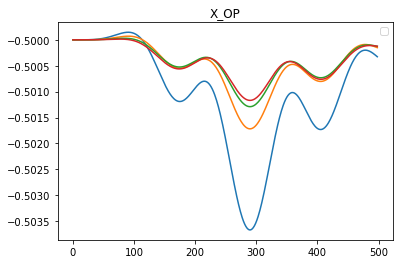

In [35]:
plt.plot(multiple_ev_results["dict_res_proj_ev_all"]["dict_res_proj_ev_T0"]["Avgs"][1])
plt.plot(multiple_ev_results["dict_res_proj_ev_all"]["dict_res_proj_ev_T1"]["Avgs"][1])
plt.plot(multiple_ev_results["dict_res_proj_ev_all"]["dict_res_proj_ev_T2"]["Avgs"][1])
plt.plot(multiple_ev_results["dict_res_proj_ev_all"]["dict_res_proj_ev_T3"]["Avgs"][1])

plt.legend()
plt.title("X_OP")

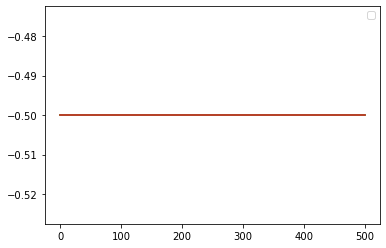

In [34]:
plt.plot(multiple_ev_results["res_exact_all"]["res_exact_T0"].expect[1])
plt.plot(multiple_ev_results["res_exact_all"]["res_exact_T1"].expect[1])
plt.plot(multiple_ev_results["res_exact_all"]["res_exact_T2"].expect[1])
plt.plot(multiple_ev_results["res_exact_all"]["res_exact_T3"].expect[1])

plt.legend()

In [ ]:
res_exactito = qutip.mesolve(H = H_H, tlist = ts, rho0 = rho_ref, e_ops = observables)
plt.plot(res_exactito.expect[3])